# Panggil Data Awal

In [319]:
import pandas as pd
import re

df = pd.read_csv("redmi6.csv", encoding='latin1')
df = df.drop('Useful', axis=1)

df.duplicated().sum()

35

In [320]:
# Hapus baris duplikat
df = df.drop_duplicates()

In [321]:
# Ambil hanya kolom yang dibutuhkan
df = df[['Rating', 'Category', 'Comments']]

# membersihkan kolom rating
df['Rating'] = df['Rating'].astype(str).str.extract(r'(\d+(\.\d+)?)')[0].astype(float)

#membersihkan kolom komentar
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)     # hapus angka & simbol
    text = re.sub(r"\s+", " ", text).strip()    # hapus spasi berlebih
    return text

df['Comments'] = df['Comments'].apply(clean_text)
df


,Rating,Category,Comments
0,4.0,Display,another midrange killer smartphone by xiaomi m...
1,3.0,Others,all ok but vry small size mobile
2,3.0,Others,quite good
3,5.0,Display,redmi has always have been the the king of bud...
4,2.0,Others,worst product from mi i am a hardcore fan of m...
...,...,...,...
275,5.0,Others,i like this phone awesome look and design im u...
276,4.0,Others,product is avasome but invoice is note include
277,3.0,Battery,redmi note note now proit seems the older the ...
278,5.0,Others,i love mi


In [322]:
df['Category'].value_counts()


Category
Others      161
Display      29
Camera       25
Battery      24
Delivery      6
Name: count, dtype: int64

# Labelling dan Analisis Sentimen Menggunakan BART

In [323]:
def label_sentiment_rating(rating):
    if rating < 3:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['Sentiment_Rating'] = df['Rating'].apply(label_sentiment_rating)


In [324]:
from transformers import pipeline

# Buat zero-shot classifier dengan framework PyTorch
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    framework="pt"
)

# Daftar label emosi
labels = ["satisfied", "unsatisfied", "angry", "neutral", "mixed"]

# Contoh prediksi untuk 1 komentar
text = "this phone is good but the camera is bad"
result = classifier(text, candidate_labels=labels)

print("Komentar:", text)
print("Label Prediksi:", result["labels"][0])
print("Semua skor:", list(zip(result["labels"], result["scores"])))


c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Komentar: this phone is good but the camera is bad
Label Prediksi: mixed
Semua skor: [('mixed', 0.7706360816955566), ('unsatisfied', 0.2089696228504181), ('neutral', 0.01135549321770668), ('satisfied', 0.004540059715509415), ('angry', 0.004498744383454323)]


In [325]:
df['Comments'].isna().sum(), (df['Comments'].astype(str).str.strip() == '').sum()

(0, 1)

In [326]:
kosong = df[df['Comments'].isna() | (df['Comments'].astype(str).str.strip() == '')]
print(kosong)


     Rating Category Comments Sentiment_Rating
163     4.0   Others                  positive


In [327]:
df.loc[df['Comments'].isna() | (df['Comments'].astype(str).str.strip() == ''), 'Comments'] = 'Good'
df['Comments'].isna().sum(), (df['Comments'].astype(str).str.strip() == '').sum()

(0, 0)

In [328]:
def predict_emotion(text):
    try:
        if pd.isna(text) or text.strip() == "":
            return "unknown"
        result = classifier(text, candidate_labels=labels)
        return result['labels'][0]
    except Exception as e:
        print(f"Error on text: {text[:30]}... → {e}")
        return "error"


# Hanya 100 data dulu (bisa diubah ke seluruh data)
df['Emotion_Label'] = df['Comments'].astype(str).apply(predict_emotion)


In [329]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download resource (cukup sekali)
nltk.download('stopwords')

# Inisialisasi stopwords dan stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Fungsi preprocessing
def preprocess(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Hapus simbol dan angka
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

# Terapkan ke kolom komentar
df['Processed_Comments'] = df['Comments'].astype(str).apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\71476\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [330]:
def emotion_to_sentiment(emotion):
    if emotion in ['unsatisfied', 'angry']:
        return 'negative'
    elif emotion == 'satisfied':
        return 'positive'
    else:
        return 'neutral'

df['Sentiment_Comments'] = df['Emotion_Label'].apply(emotion_to_sentiment)
df['Sentiment_Match'] = df['Sentiment_Comments'] == df['Sentiment_Rating']


In [331]:
# Buat kolom apakah hasilnya sama atau beda
df['Sentiment_Match'] = df['Sentiment_Rating'] == df['Sentiment_Comments']

# Buat dataset baru jika mismatch
mismatch_df = df[df['Sentiment_Match'] == False]

# Lihat jumlah perbandingan
comparison_counts = df['Sentiment_Match'].value_counts()
print("Perbandingan hasil sentiment:")
print(comparison_counts)

# Simpan mismatch untuk dianalisis lebih lanjut
mismatch_df.to_csv("sentiment_mismatch.csv", index=False)


Perbandingan hasil sentiment:
Sentiment_Match
True     171
False     74
Name: count, dtype: int64


# Belajar dari Data True Menggunakan Regresi Logistik

In [332]:
training_df = df[df['Sentiment_Match'] == True]


In [333]:
# TF-IDF vectorizer dari Comments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = training_df['Comments']
y = training_df['Emotion_Label']

vectorizer = TfidfVectorizer(max_features=1000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))


              precision    recall  f1-score   support

       mixed       0.00      0.00      0.00         2
   satisfied       0.74      1.00      0.85        26
 unsatisfied       0.00      0.00      0.00         7

    accuracy                           0.74        35
   macro avg       0.25      0.33      0.28        35
weighted avg       0.55      0.74      0.63        35



c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [334]:
df_true = df[df['Sentiment_Match'] == True]
X_true = df_true['Processed_Comments']
y_true = df_true['Emotion_Label']


In [335]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_vec = vectorizer.fit_transform(X_true)

# Latih model
clf = LogisticRegression(max_iter=300)
clf.fit(X_vec, y_true)


LogisticRegression(max_iter=300)

In [336]:
df_false = df[df['Sentiment_Match'] == False]
X_false = df_false['Processed_Comments']
X_false_vec = vectorizer.transform(X_false)


In [337]:
df_false['Emotion_Label_New'] = clf.predict(X_false_vec)


C:\Users\71476\AppData\Local\Temp\ipykernel_19200\463894245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_false['Emotion_Label_New'] = clf.predict(X_false_vec)


In [338]:
def emotion_to_sentiment(emotion):
    if emotion in ['unsatisfied', 'angry']:
        return 'negative'
    elif emotion == 'satisfied':
        return 'positive'
    else:
        return 'neutral'

df_false['Sentiment_Comments_New'] = df_false['Emotion_Label_New'].apply(emotion_to_sentiment)
df_false['Sentiment_Match_New'] = df_false['Sentiment_Comments_New'] == df_false['Sentiment_Rating']


C:\Users\71476\AppData\Local\Temp\ipykernel_19200\3655690699.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_false['Sentiment_Comments_New'] = df_false['Emotion_Label_New'].apply(emotion_to_sentiment)
C:\Users\71476\AppData\Local\Temp\ipykernel_19200\3655690699.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_false['Sentiment_Match_New'] = df_false['Sentiment_Comments_New'] == df_false['Sentiment_Rating']


In [339]:
df_false['Sentiment_Match_New'].value_counts()


Sentiment_Match_New
True     49
False    25
Name: count, dtype: int64

In [340]:
df.loc[df_false.index, 'Emotion_Label'] = df_false['Emotion_Label_New']
df.loc[df_false.index, 'Sentiment_Comments'] = df_false['Sentiment_Comments_New']
df.loc[df_false.index, 'Sentiment_Match'] = df_false['Sentiment_Match_New']


In [341]:
# Lihat jumlah perbandingan
comparison_counts = df['Sentiment_Match'].value_counts()
print("Perbandingan hasil sentiment:")
print(comparison_counts)

Perbandingan hasil sentiment:
Sentiment_Match
True     220
False     25
Name: count, dtype: int64


In [342]:
df.to_csv('redmi_hampir_ok.csv', index=False)

In [343]:
# Ambil semua data dengan hasil prediksi yang tidak sesuai rating (25 data awal)
salah25 = df[df['Sentiment_Match'] == False][[
    'Comments',
    'Rating',
    'Emotion_Label',
    'Sentiment_Comments',
    'Sentiment_Rating'
]].reset_index(drop=True)

# Tampilkan tabel
salah25


,Comments,Rating,Emotion_Label,Sentiment_Comments,Sentiment_Rating
0,quite good,3.0,satisfied,positive,neutral
1,over prised by at least around rs low light ph...,3.0,satisfied,positive,neutral
2,the product is great with quite good features ...,3.0,satisfied,positive,neutral
3,no dual g if you think new mobile you buy realme,2.0,satisfied,positive,negative
4,bad camera quality and heating problem,2.0,satisfied,positive,negative
5,awesome sound quality battery life is good gam...,3.0,satisfied,positive,neutral
6,please dontt bye camera is good but battery ba...,1.0,satisfied,positive,negative
7,both camera quality is bedits price is too hig...,1.0,satisfied,positive,negative
8,ok,1.0,satisfied,positive,negative
9,sound quality is not so good either way the mo...,3.0,satisfied,positive,neutral


In [344]:
salah25.to_csv('25_data_koreksi.csv', index=False)


# Belajar dari Data True Terbaru (Kembali Menggunakan BART)

In [345]:
df_train = df[df['Sentiment_Match'] == True]
df_salah = df[df['Sentiment_Match'] == False]


In [346]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Misalnya df_train sudah berisi 220 data
X = df_train['Comments'].astype(str).tolist()
y = df_train['Sentiment_Rating'].tolist()

# Encode label ke angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)


In [347]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='pt')


c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [348]:
import torch

class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = RatingDataset(train_encodings, y_train)
test_dataset = RatingDataset(test_encodings, y_test)


In [349]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW

model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Latih selama 3 epoch
model.train()
for epoch in range(3):
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1} selesai ✅")


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 selesai ✅
Epoch 2 selesai ✅
Epoch 3 selesai ✅


In [350]:
df_salah['combined_text'] = df_salah['Processed_Comments'] + ' rating_' + df_salah['Rating'].astype(str)


C:\Users\71476\AppData\Local\Temp\ipykernel_19200\1099362255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salah['combined_text'] = df_salah['Processed_Comments'] + ' rating_' + df_salah['Rating'].astype(str)


In [351]:
df_salah['Manual_Label'] = ['positive', 'neutral', 'neutral', 'negative', 'negative',
                            'neutral', 'negative', 'negative', 'positive', 'neutral',
                            'neutral', 'negative', 'negative', 'neutral', 'neutral',
                            'negative', 'negative', 'positive', 'positive', 'positive',
                            'positive', 'neutral', 'negative', 'positive', 'negative']

C:\Users\71476\AppData\Local\Temp\ipykernel_19200\2594373928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salah['Manual_Label'] = ['positive', 'neutral', 'neutral', 'negative', 'negative',


In [352]:
# Asumsikan model sudah dilatih dan tokenizer sudah siap

# Tokenisasi komentar
inputs = tokenizer(df_salah['Processed_Comments'].astype(str).tolist(), padding=True, truncation=True, return_tensors='pt').to(device)

# Prediksi
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()

# Decode label
df_salah['Updated_Sentiment_Rating'] = le.inverse_transform(preds)


C:\Users\71476\AppData\Local\Temp\ipykernel_19200\132984800.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salah['Updated_Sentiment_Rating'] = le.inverse_transform(preds)


In [353]:
# 1. Pastikan kolomnya ada
print(df_salah.columns.tolist())

# 2. Cek apakah ada nilai NaN
print(df_salah[['Manual_Label', 'Updated_Sentiment_Rating']].isna().sum())

# 3. Pastikan keduanya dalam format string
df_salah['Manual_Label'] = df_salah['Manual_Label'].astype(str)
df_salah['Updated_Sentiment_Rating'] = df_salah['Updated_Sentiment_Rating'].astype(str)

# 4. Bandingkan hasilnya
df_salah['Sama?'] = df_salah['Manual_Label'] == df_salah['Updated_Sentiment_Rating']

# 5. Ringkasan hasil
print(df_salah['Sama?'].value_counts())


['Rating', 'Category', 'Comments', 'Sentiment_Rating', 'Emotion_Label', 'Processed_Comments', 'Sentiment_Comments', 'Sentiment_Match', 'combined_text', 'Manual_Label', 'Updated_Sentiment_Rating']
Manual_Label                0
Updated_Sentiment_Rating    0
dtype: int64
Sama?
False    16
True      9
Name: count, dtype: int64


C:\Users\71476\AppData\Local\Temp\ipykernel_19200\244836714.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salah['Manual_Label'] = df_salah['Manual_Label'].astype(str)
C:\Users\71476\AppData\Local\Temp\ipykernel_19200\244836714.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salah['Updated_Sentiment_Rating'] = df_salah['Updated_Sentiment_Rating'].astype(str)
C:\Users\71476\AppData\Local\Temp\ipykernel_19200\244836714.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [354]:
df_salah['Manual_Label'] = df_salah['Manual_Label'].astype(str)  # pastikan sama tipe data
df_salah['Sama?'] = df_salah['Manual_Label'] == df_salah['Updated_Sentiment_Rating']


C:\Users\71476\AppData\Local\Temp\ipykernel_19200\333382780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salah['Manual_Label'] = df_salah['Manual_Label'].astype(str)  # pastikan sama tipe data
C:\Users\71476\AppData\Local\Temp\ipykernel_19200\333382780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salah['Sama?'] = df_salah['Manual_Label'] == df_salah['Updated_Sentiment_Rating']


In [355]:
df_salah['Sama?'].value_counts()


Sama?
False    16
True      9
Name: count, dtype: int64

# Update Data

In [356]:
df.loc[df_salah.index, 'Sentiment_Rating'] = df_salah['Updated_Sentiment_Rating']
df.loc[df_salah.index, 'Sentiment_Match'] = df_salah['Sama?']

In [357]:
# Buat kolom apakah hasilnya sama atau beda
df_fix['Sentiment_Match'] = df['Sentiment_Rating'] == df['Sentiment_Comments']

# Buat dataset baru jika mismatch
mismatch_df_fix = df[df['Sentiment_Match'] == False]

# Lihat jumlah perbandingan
comparison_counts_fix = df['Sentiment_Match'].value_counts()
print("Perbandingan hasil sentiment:")
print(comparison_counts_fix)

Perbandingan hasil sentiment:
Sentiment_Match
True     229
False     16
Name: count, dtype: int64


In [ ]:
df.to_csv('sisa16.csv', index=False)


# Memanggil Data dengan Label Terbaru

In [495]:
import pandas as pd
df_final = pd.read_csv("sisa16.csv")


In [496]:
df_final['Sentiment_Match'].value_counts()

Sentiment_Match
True     229
False     16
Name: count, dtype: int64

# Analisis Sentimen Kembali Menggunakan Regresi Logistik

In [497]:
df_train = df_final[df_final['Sentiment_Match'] == True].copy()
df_salah = df_final[df_final['Sentiment_Match'] == False].copy()

In [498]:
df_train

,Rating,Category,Comments,Sentiment_Rating,Emotion_Label,Processed_Comments,Sentiment_Comments,Sentiment_Match
0,4.0,Display,another midrange killer smartphone by xiaomi m...,positive,satisfied,anoth midrang killer smartphon xiaomi major hi...,positive,True
1,3.0,Others,all ok but vry small size mobile,neutral,mixed,ok vri small size mobil,neutral,True
2,3.0,Others,quite good,positive,satisfied,quit good,positive,True
3,5.0,Display,redmi has always have been the the king of bud...,positive,satisfied,redmi alway king budget segmentand yet anoth g...,positive,True
4,2.0,Others,worst product from mi i am a hardcore fan of m...,negative,unsatisfied,worst product mi hardcor fan mi one realli dis...,negative,True
...,...,...,...,...,...,...,...,...
240,5.0,Others,i like this phone awesome look and design im u...,positive,satisfied,like phone awesom look design im use phone,positive,True
241,4.0,Others,product is avasome but invoice is note include,positive,satisfied,product avasom invoic note includ,positive,True
242,3.0,Battery,redmi note note now proit seems the older the ...,negative,satisfied,redmi note note proit seem older model better ...,positive,True
243,5.0,Others,i love mi,positive,satisfied,love mi,positive,True


In [499]:
df_salah

,Rating,Category,Comments,Sentiment_Rating,Emotion_Label,Processed_Comments,Sentiment_Comments,Sentiment_Match
5,3.0,Display,over prised by at least around rs low light ph...,positive,satisfied,prise least around rs low light photo bad one ...,positive,False
16,3.0,Others,the product is great with quite good features ...,positive,satisfied,product great quit good featur great fan xiaom...,positive,False
24,2.0,Others,no dual g if you think new mobile you buy realme,positive,satisfied,dual g think new mobil buy realm,positive,False
27,2.0,Camera,bad camera quality and heating problem,positive,satisfied,bad camera qualiti heat problem,positive,False
29,3.0,Battery,awesome sound quality battery life is good gam...,positive,satisfied,awesom sound qualiti batteri life good game go...,positive,False
33,1.0,Battery,please dontt bye camera is good but battery ba...,positive,satisfied,pleas dontt bye camera good batteri back good,positive,False
36,1.0,Camera,both camera quality is bedits price is too hig...,positive,satisfied,camera qualiti bedit price high qualiti lowest,positive,False
61,3.0,Others,sound quality is not so good either way the mo...,positive,satisfied,sound qualiti good either way mobil best segment,positive,False
63,1.0,Battery,sometimes automatically speaker on and little ...,positive,satisfied,sometim automat speaker littl hang problem cam...,positive,False
76,3.0,Others,sound qulity not dolby and processor performan...,positive,satisfied,sound quliti dolbi processor perform ok,positive,False


In [500]:
df_salah['Manual_Sentiment_Rating'] = ['neutral', 'neutral', 'negative', 'negative', 'neutral',
                            'negative', 'negative', 'neutral', 'negative', 'neutral',
                            'positive', 'neutral', 'negative', 'neutral', 'negative',
                            'negative']
df_salah['Manual_Sentiment_Comments'] = ['neutral', 'neutral', 'negative', 'negative', 'neutral',
                            'negative', 'negative', 'neutral', 'neutral', 'negative',
                            'negative', 'neutral', 'negative', 'negative', 'neutral',
                            'negative']

In [501]:
df_salah

,Rating,Category,Comments,Sentiment_Rating,Emotion_Label,Processed_Comments,Sentiment_Comments,Sentiment_Match,Manual_Sentiment_Rating,Manual_Sentiment_Comments
5,3.0,Display,over prised by at least around rs low light ph...,positive,satisfied,prise least around rs low light photo bad one ...,positive,False,neutral,neutral
16,3.0,Others,the product is great with quite good features ...,positive,satisfied,product great quit good featur great fan xiaom...,positive,False,neutral,neutral
24,2.0,Others,no dual g if you think new mobile you buy realme,positive,satisfied,dual g think new mobil buy realm,positive,False,negative,negative
27,2.0,Camera,bad camera quality and heating problem,positive,satisfied,bad camera qualiti heat problem,positive,False,negative,negative
29,3.0,Battery,awesome sound quality battery life is good gam...,positive,satisfied,awesom sound qualiti batteri life good game go...,positive,False,neutral,neutral
33,1.0,Battery,please dontt bye camera is good but battery ba...,positive,satisfied,pleas dontt bye camera good batteri back good,positive,False,negative,negative
36,1.0,Camera,both camera quality is bedits price is too hig...,positive,satisfied,camera qualiti bedit price high qualiti lowest,positive,False,negative,negative
61,3.0,Others,sound quality is not so good either way the mo...,positive,satisfied,sound qualiti good either way mobil best segment,positive,False,neutral,neutral
63,1.0,Battery,sometimes automatically speaker on and little ...,positive,satisfied,sometim automat speaker littl hang problem cam...,positive,False,negative,neutral
76,3.0,Others,sound qulity not dolby and processor performan...,positive,satisfied,sound quliti dolbi processor perform ok,positive,False,neutral,negative


In [502]:
import re

# 1. List kata negatif
neg_words = [
    "poor", "bad", "dont", "didnt", "disappointed",
    "lag", "not", "worst", "low", "waste", "broken",
    "slow", "issue", "problem", "no", "never"
]

# 2. Fungsi preprocessing
def full_preprocess(text):
    text = text.lower()

    # Tagging kata negatif
    for word in neg_words:
        text = re.sub(rf"\b{word}\b", f"NEG_{word.upper()}", text)

    # Tagging transisi opini
    text = re.sub(r'\bbut\b', 'BUT_TURN', text)

    return text

# 3. Contoh pakai
example = "The screen is good but the battery is poor and slow"
print(full_preprocess(example))


the screen is good BUT_TURN the battery is NEG_POOR and NEG_SLOW


In [503]:
df_train['Processed_Comments'] = df_train['Comments'].astype(str).apply(full_preprocess)
df_salah['Processed_Comments'] = df_salah['Comments'].astype(str).apply(full_preprocess)

In [504]:
from sklearn.model_selection import train_test_split

X = df_train['Processed_Comments']
y = df_train['Sentiment_Comments'] 

# Stratify agar pembagian label seimbang
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [505]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [506]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)


LogisticRegression(max_iter=1000)

In [507]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.00      0.00      0.00         2
    positive       0.83      1.00      0.90        38

    accuracy                           0.83        46
   macro avg       0.28      0.33      0.30        46
weighted avg       0.68      0.83      0.75        46



c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [508]:
X_salah = tfidf.transform(df_salah['Processed_Comments'])
df_salah['Predicted_Sentiment_Comments'] = model.predict(X_salah)


In [509]:
df_salah['Komentar_vs_Rating'] = df_salah['Predicted_Sentiment_Comments'] == df_salah['Manual_Sentiment_Rating']


In [510]:
df_final.loc[df_salah.index, 'Manual_Sentiment_Comments'] = df_salah['Predicted_Sentiment_Comments']
df_final.loc[df_salah.index, 'Sentiment_Match'] = df_salah['Komentar_vs_Rating']

In [511]:
df_final['Sentiment_Rating'] = df_final['Sentiment_Rating'].str.strip().str.lower()
df_final['Sentiment_Comments'] = df_final['Sentiment_Comments'].str.strip().str.lower()

df_final['Sentiment_Match'] = df_final['Sentiment_Rating'] == df_final['Sentiment_Comments']


In [512]:
# Buat kolom apakah hasilnya sama atau beda
df_final['Sentiment_Match'] = df_final['Sentiment_Rating'] == df_final['Sentiment_Comments']

# Buat dataset baru jika mismatch
mismatch_df_fix = df_final[df_final['Sentiment_Match'] == False]

# Lihat jumlah perbandingan
comparison_counts_fix = df_final['Sentiment_Match'].value_counts()
print("Perbandingan hasil sentiment:")
print(comparison_counts_fix)

Perbandingan hasil sentiment:
Sentiment_Match
True     243
False      2
Name: count, dtype: int64


In [513]:
df_final[df_final['Sentiment_Match'] == False]

,Rating,Category,Comments,Sentiment_Rating,Emotion_Label,Processed_Comments,Sentiment_Comments,Sentiment_Match,Manual_Sentiment_Comments
82,1.0,Others,im fan mi but no dual volte waste of money,negative,satisfied,im fan mi dual volt wast money,positive,False,NaN
242,3.0,Battery,redmi note note now proit seems the older the ...,negative,satisfied,redmi note note proit seem older model better ...,positive,False,NaN


## Manual Labelling

In [514]:
df_final.loc[82, ['Sentiment_Rating', 'Sentiment_Comments']] = ['negative', 'negative']
df_final.loc[242, ['Sentiment_Rating', 'Sentiment_Comments']] = ['neutral', 'neutral']


In [515]:
df_final['Sentiment_Match'] = df_final['Sentiment_Rating'] == df_final['Sentiment_Comments']

In [516]:
# Buat kolom apakah hasilnya sama atau beda
df_final['Sentiment_Match'] = df_final['Sentiment_Rating'] == df_final['Sentiment_Comments']

# Buat dataset baru jika mismatch
mismatch_df_fix = df_final[df_final['Sentiment_Match'] == False]

# Lihat jumlah perbandingan
comparison_counts_fix = df_final['Sentiment_Match'].value_counts()
print("Perbandingan hasil sentiment:")
print(comparison_counts_fix)

Perbandingan hasil sentiment:
Sentiment_Match
True    245
Name: count, dtype: int64


In [517]:
df_final['final_sentiment'] = df_final['Sentiment_Rating']

In [518]:
df_final = df_final[['Category', 'Comments', 'Rating', 'final_sentiment']]

In [519]:
df_final

,Category,Comments,Rating,final_sentiment
0,Display,another midrange killer smartphone by xiaomi m...,4.0,positive
1,Others,all ok but vry small size mobile,3.0,neutral
2,Others,quite good,3.0,positive
3,Display,redmi has always have been the the king of bud...,5.0,positive
4,Others,worst product from mi i am a hardcore fan of m...,2.0,negative
...,...,...,...,...
240,Others,i like this phone awesome look and design im u...,5.0,positive
241,Others,product is avasome but invoice is note include,4.0,positive
242,Battery,redmi note note now proit seems the older the ...,3.0,neutral
243,Others,i love mi,5.0,positive


In [520]:
df_final.to_csv('clean_redmi.csv', index=False)

# Analisis Kategori

In [13]:
import pandas as pd
df = pd.read_csv("clean_redmi.csv")

In [14]:
df['Category'].value_counts()

Category
Others      161
Display      29
Camera       25
Battery      24
Delivery      6
Name: count, dtype: int64

In [15]:
df_train_cat = df[df['Category'].isin(['Display', 'Battery', 'Camera', 'Delivery'])].copy()
df_pred_cat = df[df['Category'] == 'Others'].copy()


In [17]:
from transformers import pipeline

# Inisialisasi zero-shot classifier dari BART
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", framework="pt")

# Definisikan label kategori
labels = ["Display", "Battery", "Camera", "Delivery"]

# Prediksi kategori untuk data "Others"
df_pred_cat['Predicted_Categories'] = df_pred_cat['Comments'].apply(
    lambda x: classifier(x, candidate_labels=labels, multi_label=True)['labels']
)

def get_labels_above_threshold(text, threshold=0.5):
    result = classifier(text, candidate_labels=labels, multi_label=True)
    return [label for label, score in zip(result['labels'], result['scores']) if score >= threshold]

df_pred_cat['Predicted_Categories'] = df_pred_cat['Comments'].apply(lambda x: get_labels_above_threshold(x))


# Cek hasil prediksi
print(df_pred_cat[['Comments', 'Predicted_Categories']].head())

c:\Users\71476\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


                                            Comments  \
1                   all ok but vry small size mobile   
2                                         quite good   
4  worst product from mi i am a hardcore fan of m...   
8                                               wooo   
9  realme is sub brand of oppo he give money to a...   

                   Predicted_Categories  
1            [Display, Camera, Battery]  
2  [Display, Camera, Battery, Delivery]  
4                                    []  
8                     [Display, Camera]  
9                             [Display]  


In [18]:
def get_labels_above_threshold(comment, threshold=0.4):
    result = classifier(comment, candidate_labels=labels, multi_label=True)
    labels_above_threshold = [label for label, score in zip(result['labels'], result['scores']) if score > threshold]
    return labels_above_threshold

df_pred_cat['Predicted_Categories'] = df_pred_cat['Comments'].apply(get_labels_above_threshold)


In [19]:
df_pred_expanded = df_pred_cat.explode('Predicted_Categories')
df_pred_expanded = df_pred_expanded.rename(columns={'Predicted_Categories': 'Predicted_Category'})


In [20]:
# Drop 'Others' dulu dari df utama
df_cleaned = df[df['Category'] != 'Others'].copy()

# Tambahkan data prediksi hasil multi-label
df_final = pd.concat([df_cleaned, df_pred_expanded], ignore_index=True)

# Pastikan 'Category' diupdate
df_final['Category'] = df_final['Predicted_Category']


In [22]:
print(df['Category'].value_counts())

Category
Others      161
Display      29
Camera       25
Battery      24
Delivery      6
Name: count, dtype: int64


In [21]:
print(df_final['Category'].value_counts())

Category
Delivery    116
Display     114
Camera      108
Battery      55
Name: count, dtype: int64


## Distribusi Data

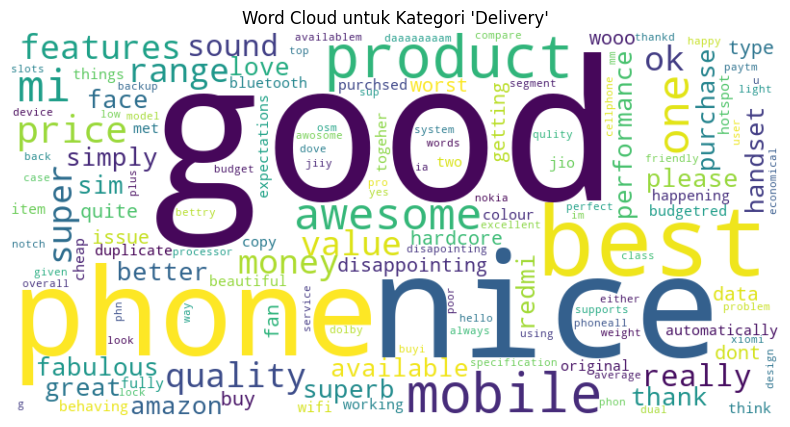

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_display = ' '.join(df_final[df_final['Category'] == 'Delivery']['Comments'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_display)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud untuk Kategori 'Delivery'")
plt.show()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_display = ' '.join(df_final[df_final['Category'] == 'Display']['Comments'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_display)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud untuk Kategori 'Display'")
plt.show()


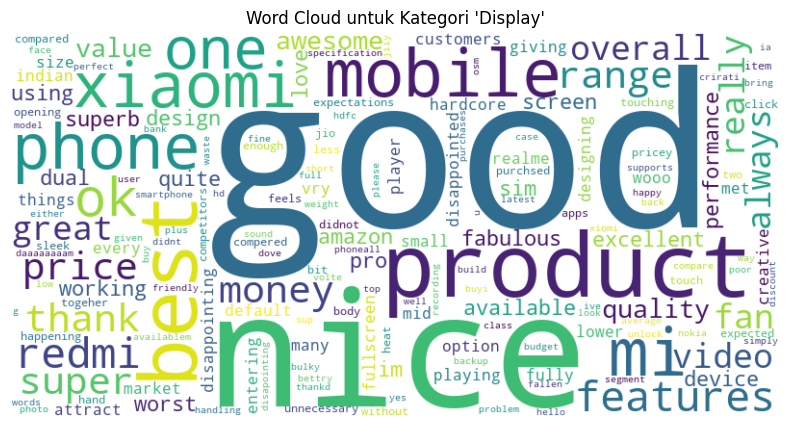

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_display = ' '.join(df_final[df_final['Category'] == 'Camera']['Comments'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_display)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud untuk Kategori 'Display'")
plt.show()


In [26]:
# Buat tabel kategori vs sentimen
category_sentiment = pd.crosstab(df_final['Category'], df_final['final_sentiment'])

print(category_sentiment)


final_sentiment  negative  neutral  positive
Category                                    
Battery                 0        1        54
Camera                  8        3        97
Delivery                5        0       111
Display                 5        5       104


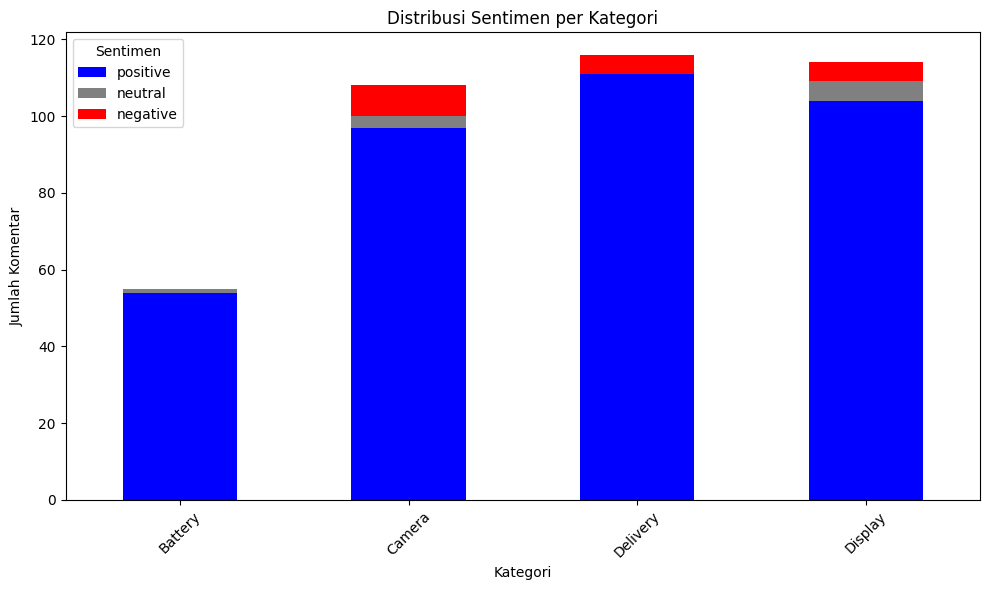

In [27]:
category_sentiment = category_sentiment[['positive', 'neutral', 'negative']]

# Visualisasi stacked bar dengan warna sesuai urutan
category_sentiment.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['blue', 'gray', 'red']  
)

plt.title('Distribusi Sentimen per Kategori')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Komentar')
plt.xticks(rotation=45)
plt.legend(title='Sentimen')
plt.tight_layout()
plt.show()


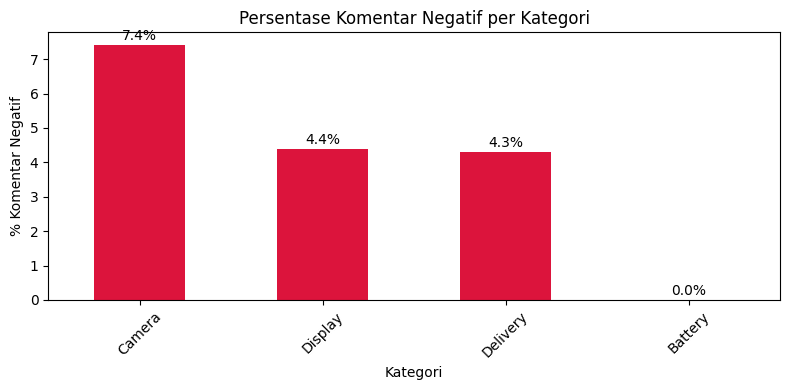

In [28]:
# Hitung persentase komentar negatif dari total per kategori
category_sentiment['Total'] = category_sentiment.sum(axis=1)
category_sentiment['Negatif_%'] = (category_sentiment['negative'] / category_sentiment['Total']) * 100


# Plot batang
ax = category_sentiment['Negatif_%'].sort_values(ascending=False).plot(
    kind='bar', figsize=(8, 4), color='crimson'
)

# Tambahkan label angka di atas batang
for i, val in enumerate(category_sentiment['Negatif_%'].sort_values(ascending=False)):
    ax.text(i, val + 0.05, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)  # lebih dekat

# Judul dan label
plt.title('Persentase Komentar Negatif per Kategori')
plt.ylabel('% Komentar Negatif')
plt.xlabel('Kategori')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
